# Prepare

In [2]:
!nvidia-smi

Sun Dec 18 08:36:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd "/content/drive/MyDrive/CE Project"
!ls

/content/drive/MyDrive/CE Project
 data   softmax.ipynb  'Use Library.ipynb'


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
from sklearn.metrics import accuracy_score, f1_score
from keras.datasets import mnist, cifar10
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import OneHotEncoder
import random

In [5]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_everything(22)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define model

In [26]:
def softmax_stable(Z):
    e_z = torch.exp(Z - torch.max(Z, dim=1, keepdim=True).values)
    A = e_z / e_z.sum(dim=1, keepdim=True)
    return A

def softmax_loss(X, y, W):
    A = softmax_stable(torch.mm(X, W))
    # print(torch.log(A)[0][0])
    return -torch.mean(torch.sum(y * torch.log(A), dim=1))

def softmax_grad(X, y, W):
    A = softmax_stable(torch.mm(X, W))
    A = A - y
    return torch.mm(X.T, A.to(torch.float32)) / X.shape[0]

def softmax_fit(X, y, W, lr=0.05, epochs=500, tol=1e-5, batch_size=32):
    W_old = torch.clone(W)
    ep = 0
    loss_hist = [softmax_loss(X, y, W).cpu().numpy()]
    N = X.shape[0]
    batches = int(np.ceil(N/batch_size))
    
    while ep < epochs:
        ep += 1
        mix_ids = torch.randperm(N)

        for i in range(batches):
            batch_ids = mix_ids[batch_size*i : min(batch_size*(i+1), N)]
            X_batch, y_batch = X[batch_ids], y[batch_ids]
            W = W - lr * softmax_grad(X_batch, y_batch, W)

        loss_hist.append(softmax_loss(X, y, W).cpu().numpy())
        if ep % 5 == 0:
            print('Epoch:', ep, 'loss:', loss_hist[-1])        
        # if torch.linalg.norm(W - W_old) / torch.numel(W) < tol:
        #     print('Small change in weights')
        #     break
        
        W_old = W
    
    return W, loss_hist

def pred(W, X):
    A = softmax_stable(torch.mm(X, W))
    return torch.argmax(A, dim=1)

# 1. MNIST

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(y_train[0])
le = OneHotEncoder()
y_train = le.fit_transform(y_train.reshape(-1, 1)).toarray()
print(y_train[0])

X_train = X_train.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.reshape(-1, 784)
X_test = X_test.astype('float32')

# normalize
X_train /= 255
X_test /= 255
print('Train samples:', X_train.shape)
print('Test samples:', X_test.shape)

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Train samples: (60000, 784)
Test samples: (10000, 784)


In [ ]:
X_train = torch.from_numpy(X_train).to(device).to(torch.float64)
y_train = torch.from_numpy(y_train).to(device).to(torch.float64)
X_test = torch.from_numpy(X_test).to(device).to(torch.float64)
# y_test = torch.from_numpy(y_test).to(device)

In [ ]:
W_init = torch.randn(X_train.shape[1], 10).to(device).to(torch.float64)

### Learning rate = 0.05

In [ ]:
lr = 0.05
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=100)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: 1.0050852689874863
Epoch: 2 loss: 0.7591380941943897
Epoch: 3 loss: 0.6588125297089673
Epoch: 4 loss: 0.5990488325049613
Epoch: 5 loss: 0.5558878817162045
Epoch: 6 loss: 0.5247929821539907
Epoch: 7 loss: 0.4989934926714717
Epoch: 8 loss: 0.4799748531061427
Epoch: 9 loss: 0.46459013822457457
Epoch: 10 loss: 0.44823552310751646
Epoch: 11 loss: 0.4372959813991584
Epoch: 12 loss: 0.42552777169417894
Epoch: 13 loss: 0.4147900882207914
Epoch: 14 loss: 0.4066763542851722
Epoch: 15 loss: 0.3980942880470252
Epoch: 16 loss: 0.3914130003234972
Epoch: 17 loss: 0.38499574994309194
Epoch: 18 loss: 0.38676417735842195
Epoch: 19 loss: 0.37495327303505827
Epoch: 20 loss: 0.3691764343705001
Epoch: 21 loss: 0.36372985008449993
Epoch: 22 loss: 0.3594064990022005
Epoch: 23 loss: 0.3545985693839988
Epoch: 24 loss: 0.35011875105256735
Epoch: 25 loss: 0.3457495345163328
Epoch: 26 loss: 0.342670596097305
Epoch: 27 loss: 0.3396348554886998
Epoch: 28 loss: 0.33722035394318567
Epoch: 29 loss: 0.336

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

91.81

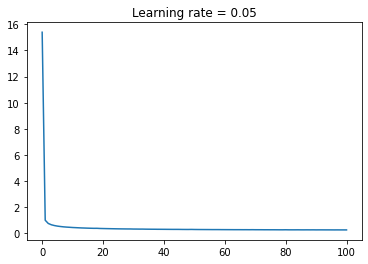

In [ ]:
plt.plot(loss_hist)
plt.title('Learning rate = {}'.format(lr))
plt.show()

### Learning rate = 2

In [ ]:
lr = 2
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=100)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: 0.7673663116659802
Epoch: 2 loss: 0.6280016032636069
Epoch: 3 loss: 0.6542755841354954
Epoch: 4 loss: 0.5231902141698053
Epoch: 5 loss: 0.5628570915267369
Epoch: 6 loss: 0.5436293032372335
Epoch: 7 loss: 0.5923124798058358
Epoch: 8 loss: 0.6409902048109039
Epoch: 9 loss: 0.5600415541342892
Epoch: 10 loss: 0.5260764846910239
Epoch: 11 loss: 0.5159342718510014
Epoch: 12 loss: 0.6459661259320045
Epoch: 13 loss: 0.6720209250890551
Epoch: 14 loss: 0.6093355309747206
Epoch: 15 loss: 0.515906640191166
Epoch: 16 loss: 0.8060525572485865
Epoch: 17 loss: 0.6108030511718493
Epoch: 18 loss: 0.5221137199363802
Epoch: 19 loss: 1.0728068787956067
Epoch: 20 loss: 0.5698410066235908
Epoch: 21 loss: 0.5849812919348736
Epoch: 22 loss: 0.4886979512061652
Epoch: 23 loss: 0.5260788504874219
Epoch: 24 loss: 0.7901780692203434
Epoch: 25 loss: 0.5083163850778047
Epoch: 26 loss: 0.5113137021278238
Epoch: 27 loss: 0.9411164597200848
Epoch: 28 loss: 0.6074071559284149
Epoch: 29 loss: 0.569201166236

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

89.71000000000001

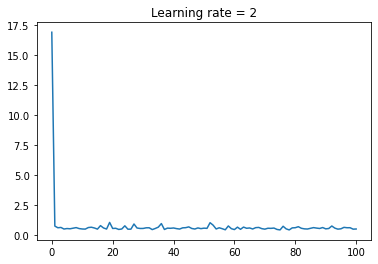

In [ ]:
plt.plot(loss_hist)
plt.title('Learning rate = {}'.format(lr))
plt.show()

### Learning rate = 0.0001

In [ ]:
lr = 0.0001
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: 14.450611240117986
Epoch: 2 loss: 13.656242521030116
Epoch: 3 loss: 12.954700578641749
Epoch: 4 loss: 12.316254386524951
Epoch: 5 loss: 11.725807676707515
Epoch: 6 loss: 11.175713426576982
Epoch: 7 loss: 10.663340094582646
Epoch: 8 loss: 10.18874560714353
Epoch: 9 loss: 9.7534570878479
Epoch: 10 loss: 9.358662149340146
Epoch: 11 loss: 9.003955419739626
Epoch: 12 loss: 8.686398104601356
Epoch: 13 loss: 8.40222597784167
Epoch: 14 loss: 8.146466229709825
Epoch: 15 loss: 7.914454723196382
Epoch: 16 loss: 7.70202706765665
Epoch: 17 loss: 7.505886402703849
Epoch: 18 loss: 7.323265624883801
Epoch: 19 loss: 7.152021257353057
Epoch: 20 loss: 6.990509052438716
Epoch: 21 loss: 6.837374031096477
Epoch: 22 loss: 6.691573117512654
Epoch: 23 loss: 6.552296512480195
Epoch: 24 loss: 6.418929771532006
Epoch: 25 loss: 6.290918144970497
Epoch: 26 loss: 6.167831659056782
Epoch: 27 loss: 6.049285347528778
Epoch: 28 loss: 5.9349754171014055
Epoch: 29 loss: 5.824662849893179
Epoch: 30 loss: 5.7

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

70.73

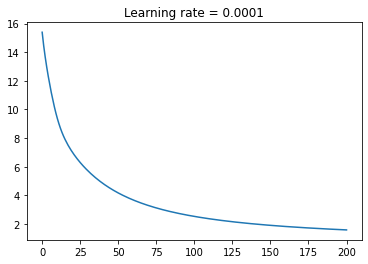

In [ ]:
plt.plot(loss_hist)
plt.title('Learning rate = {}'.format(lr))
plt.show()

# Flower

In [ ]:
# Đường dẫn
features_path = '/content/drive/MyDrive/CE Project/data/flower/flower_features.sav'
labels_path = '/content/drive/MyDrive/CE Project/data/flower/flower_labels.sav'

# Load dữ liệu
features = np.array(pickle.load(open(features_path, 'rb')))
labels = np.array(pickle.load(open(labels_path, 'rb')))

In [ ]:
# Chia traing set, test set tỉ lệ 80-20
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# max_values = np.max(X_train)
# min_values = np.min(X_train)
# a, b = 0, 1
# X_train = a + (X_train - min_values) * (b-a) / (max_values - min_values)
# X_test = a + (X_test - min_values) * (b-a) / (max_values - min_values)

In [ ]:
print(y_train[0])
le = OneHotEncoder()
y_train = le.fit_transform(y_train.reshape(-1, 1)).toarray()
print(y_train[0])
print('Train samples:', X_train.shape)
print('Test samples:', X_test.shape)

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Train samples: (1088, 25088)
Test samples: (272, 25088)


In [ ]:
X_train = torch.from_numpy(X_train).to(device).to(torch.float64)
y_train = torch.from_numpy(y_train).to(device).to(torch.float64)
X_test = torch.from_numpy(X_test).to(device).to(torch.float64)
# y_test = torch.from_numpy(y_test).to(device)

In [ ]:
W_init = torch.randn(X_train.shape[1], y_train.shape[1]).to(device).to(torch.float64)

### lr = 0.5

In [ ]:
lr = 0.5
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: nan
Epoch: 2 loss: nan
Epoch: 3 loss: nan
Epoch: 4 loss: nan
Epoch: 5 loss: nan
Epoch: 6 loss: nan
Epoch: 7 loss: nan
Epoch: 8 loss: nan
Epoch: 9 loss: nan
Epoch: 10 loss: nan
Epoch: 11 loss: nan
Epoch: 12 loss: nan
Epoch: 13 loss: nan
Epoch: 14 loss: nan
Epoch: 15 loss: nan
Epoch: 16 loss: nan
Epoch: 17 loss: nan
Epoch: 18 loss: nan
Epoch: 19 loss: nan
Epoch: 20 loss: nan
Epoch: 21 loss: nan
Epoch: 22 loss: nan
Epoch: 23 loss: nan
Epoch: 24 loss: nan
Epoch: 25 loss: nan
Epoch: 26 loss: nan
Epoch: 27 loss: nan
Epoch: 28 loss: nan
Epoch: 29 loss: nan
Epoch: 30 loss: nan
Epoch: 31 loss: nan
Epoch: 32 loss: nan
Epoch: 33 loss: nan
Epoch: 34 loss: nan
Epoch: 35 loss: nan
Epoch: 36 loss: nan
Epoch: 37 loss: nan
Epoch: 38 loss: nan
Epoch: 39 loss: nan
Epoch: 40 loss: nan
Epoch: 41 loss: nan
Epoch: 42 loss: nan
Epoch: 43 loss: nan
Epoch: 44 loss: nan
Epoch: 45 loss: nan
Epoch: 46 loss: nan
Epoch: 47 loss: nan
Epoch: 48 loss: nan
Epoch: 49 loss: nan
Epoch: 50 loss: nan
Epoch: 51

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

90.07352941176471

### lr = 1

In [ ]:
lr = 1e6
start = time.time()
W, _ = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: nan
Epoch: 2 loss: nan
Epoch: 3 loss: nan
Epoch: 4 loss: nan
Epoch: 5 loss: nan
Epoch: 6 loss: nan
Epoch: 7 loss: nan
Epoch: 8 loss: nan
Epoch: 9 loss: nan
Epoch: 10 loss: nan
Epoch: 11 loss: nan
Epoch: 12 loss: nan
Epoch: 13 loss: nan
Epoch: 14 loss: nan
Epoch: 15 loss: nan
Epoch: 16 loss: nan
Epoch: 17 loss: nan
Epoch: 18 loss: nan
Epoch: 19 loss: nan
Epoch: 20 loss: nan
Epoch: 21 loss: nan
Epoch: 22 loss: nan
Epoch: 23 loss: nan
Epoch: 24 loss: nan
Epoch: 25 loss: nan
Epoch: 26 loss: nan
Epoch: 27 loss: nan
Epoch: 28 loss: nan
Epoch: 29 loss: nan
Epoch: 30 loss: nan
Epoch: 31 loss: nan
Epoch: 32 loss: nan
Epoch: 33 loss: nan
Epoch: 34 loss: nan
Epoch: 35 loss: nan
Epoch: 36 loss: nan
Epoch: 37 loss: nan
Epoch: 38 loss: nan
Epoch: 39 loss: nan
Epoch: 40 loss: nan
Epoch: 41 loss: nan
Epoch: 42 loss: nan
Epoch: 43 loss: nan
Epoch: 44 loss: nan
Epoch: 45 loss: nan
Epoch: 46 loss: nan
Epoch: 47 loss: nan
Epoch: 48 loss: nan
Epoch: 49 loss: nan
Epoch: 50 loss: nan
Epoch: 51

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

89.70588235294117

### lr=0.00001

In [ ]:
lr = 1e-5
start = time.time()
W, _ = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: nan
Epoch: 2 loss: nan
Epoch: 3 loss: nan
Epoch: 4 loss: nan
Epoch: 5 loss: nan
Epoch: 6 loss: nan
Epoch: 7 loss: nan
Epoch: 8 loss: nan
Epoch: 9 loss: nan
Epoch: 10 loss: nan
Epoch: 11 loss: nan
Epoch: 12 loss: nan
Epoch: 13 loss: nan
Epoch: 14 loss: nan
Epoch: 15 loss: nan
Epoch: 16 loss: nan
Epoch: 17 loss: nan
Epoch: 18 loss: nan
Epoch: 19 loss: nan
Epoch: 20 loss: nan
Epoch: 21 loss: nan
Epoch: 22 loss: nan
Epoch: 23 loss: nan
Epoch: 24 loss: nan
Epoch: 25 loss: nan
Epoch: 26 loss: nan
Epoch: 27 loss: nan
Epoch: 28 loss: nan
Epoch: 29 loss: nan
Epoch: 30 loss: nan
Epoch: 31 loss: nan
Epoch: 32 loss: nan
Epoch: 33 loss: nan
Epoch: 34 loss: nan
Epoch: 35 loss: nan
Epoch: 36 loss: nan
Epoch: 37 loss: nan
Epoch: 38 loss: nan
Epoch: 39 loss: nan
Epoch: 40 loss: nan
Epoch: 41 loss: nan
Epoch: 42 loss: nan
Epoch: 43 loss: nan
Epoch: 44 loss: nan
Epoch: 45 loss: nan
Epoch: 46 loss: nan
Epoch: 47 loss: nan
Epoch: 48 loss: nan
Epoch: 49 loss: nan
Epoch: 50 loss: nan
Epoch: 51

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

13.23529411764706

# vnnews

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Đường dẫn
train_x_path = '/content/drive/MyDrive/CE Project/data/vnnews/train_x.sav'
train_y_path = '/content/drive/MyDrive/CE Project/data/vnnews/train_y.sav'
test_x_path = '/content/drive/MyDrive/CE Project/data/vnnews/test_x.sav'
test_y_path = '/content/drive/MyDrive/CE Project/data/vnnews/test_y.sav'

# Load dữ liệu
X_train = np.array(pickle.load(open(train_x_path, 'rb')))
y_train = np.array(pickle.load(open(train_y_path, 'rb')))
X_test = np.array(pickle.load(open(test_x_path, 'rb')))
y_test = np.array(pickle.load(open(test_y_path, 'rb')))

In [ ]:
feature_extractor = Pipeline([
    # Chuyển tập dữ liệu sang dạng vector count dựa trên một vocab chung (BoW), loại bỏ những word có tần suất xuất hiện > 0.8
    ('vectorize', CountVectorizer(max_df=0.8, encoding='utf-16')),
    
    # Áp dụng TF-IDF để trích chọn đặc trưng (extract feature)
    ('feature extracter', TfidfTransformer())
])

X_train = feature_extractor.fit_transform(X_train, y_train)
X_test = feature_extractor.transform(X_test)
print('Kích thước vector input: ', X_train.shape)
print('Kích thước vector test', X_test.shape)

Kích thước vector input:  (14375, 79170)
Kích thước vector test (12076, 79170)


In [ ]:
X_train = X_train.astype('float32').toarray()
X_test = X_test.astype('float32').toarray()

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
print(y_train[0])
le = OneHotEncoder()
y_train = le.fit_transform(y_train.reshape(-1, 1)).toarray()
print(y_train[0])
print('Train samples:', X_train.shape)
print('Test samples:', X_test.shape)

0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Train samples: (14375, 79170)
Test samples: (12076, 79170)


In [ ]:
X_train = torch.from_numpy(X_train).to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test).to(device)
# y_test = torch.from_numpy(y_test).to(device)

In [ ]:
W_init = torch.randn(X_train.shape[1], y_train.shape[1]).to(device)

### lr=0.005

In [ ]:
lr = 0.005
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: 3.7223593578214227
Epoch: 2 loss: 3.7141233604783594
Epoch: 3 loss: 3.705896602680372
Epoch: 4 loss: 3.6976909314176307
Epoch: 5 loss: 3.6894921837827432
Epoch: 6 loss: 3.6813066618007158
Epoch: 7 loss: 3.673142066666354
Epoch: 8 loss: 3.6649900587092272
Epoch: 9 loss: 3.656843026053387
Epoch: 10 loss: 3.648720672806449
Epoch: 11 loss: 3.640606170366121
Epoch: 12 loss: 3.632512757857986
Epoch: 13 loss: 3.624426461611623
Epoch: 14 loss: 3.616350785624462
Epoch: 15 loss: 3.608295301859275
Epoch: 16 loss: 3.600253590557886
Epoch: 17 loss: 3.592239187900916
Epoch: 18 loss: 3.5842484598159787
Epoch: 19 loss: 3.576265230761403
Epoch: 20 loss: 3.5682968981452605
Epoch: 21 loss: 3.560344343943181
Epoch: 22 loss: 3.5524201720559074
Epoch: 23 loss: 3.544505041526711
Epoch: 24 loss: 3.53660955420266
Epoch: 25 loss: 3.5287305702893628
Epoch: 26 loss: 3.520869403606912
Epoch: 27 loss: 3.51302714794926
Epoch: 28 loss: 3.505201890932995
Epoch: 29 loss: 3.4973898446787954
Epoch: 30 loss

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

31.525339516396155

### lr=500

In [ ]:
lr = 500
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: 0.15477553626988
Epoch: 2 loss: 0.06425542486624398
Epoch: 3 loss: 0.052886948393351785
Epoch: 4 loss: 0.046301111164596856
Epoch: 5 loss: 0.04555983159459112
Epoch: 6 loss: 0.043215872368521896
Epoch: 7 loss: 0.05638011187885295
Epoch: 8 loss: 0.04414282143061834
Epoch: 9 loss: 0.042282428599296124
Epoch: 10 loss: 0.04370518944871227
Epoch: 11 loss: 0.04401826700516101
Epoch: 12 loss: 0.04574003384229233
Epoch: 13 loss: 0.04560140217039733
Epoch: 14 loss: 0.046086777763384656
Epoch: 15 loss: 0.03935977843510316
Epoch: 16 loss: nan
Epoch: 17 loss: 0.05781795667196744
Epoch: 18 loss: 0.05201993904637122
Epoch: 19 loss: 0.04061393740477782
Epoch: 20 loss: 0.03907449559737919
Epoch: 21 loss: 0.04635253242005802
Epoch: 22 loss: 0.03662102041820172
Epoch: 23 loss: 0.04691434902566318
Epoch: 24 loss: 0.04174569583981729
Epoch: 25 loss: 0.03989597219226689
Epoch: 26 loss: 0.04083796541293442
Epoch: 27 loss: 0.048092158844019184
Epoch: 28 loss: 0.04776926952906374
Epoch: 29 loss

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

89.26796952633322

### lr=50

In [ ]:
lr = 50
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: 0.19773483166736003
Epoch: 2 loss: 0.10061999518822153
Epoch: 3 loss: 0.06303853796423332
Epoch: 4 loss: 0.045717800246427576
Epoch: 5 loss: 0.03668514605169586
Epoch: 6 loss: 0.03196628576960547
Epoch: 7 loss: 0.02668004897494943
Epoch: 8 loss: 0.024153648340320747
Epoch: 9 loss: 0.021510036559206438
Epoch: 10 loss: 0.020166990679962638
Epoch: 11 loss: 0.01855434868006043
Epoch: 12 loss: 0.017665922836367646
Epoch: 13 loss: 0.01631046514756304
Epoch: 14 loss: 0.015418614748896053
Epoch: 15 loss: 0.014808425142503353
Epoch: 16 loss: 0.014664444415451226
Epoch: 17 loss: 0.013578200929004776
Epoch: 18 loss: 0.013267741448277196
Epoch: 19 loss: 0.012776408768366205
Epoch: 20 loss: 0.012329885613028155
Epoch: 21 loss: 0.011922392343218405
Epoch: 22 loss: 0.012080368346420296
Epoch: 23 loss: 0.011686968587003358
Epoch: 24 loss: 0.011017338300688337
Epoch: 25 loss: 0.010817904662910167
Epoch: 26 loss: 0.010592798390864362
Epoch: 27 loss: 0.010335849313325022
Epoch: 28 loss: 0.

In [ ]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

90.41901291818483

# cifar10

In [8]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, X_test.shape)

170498071/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [9]:
X_train = np.array(pickle.load(open('/content/drive/MyDrive/CE Project/data/cifar10/train_features.sav', 'rb')))
y_train = np.array(pickle.load(open('/content/drive/MyDrive/CE Project/data/cifar10/y_train.sav', 'rb')))
X_test = np.array(pickle.load(open('/content/drive/MyDrive/CE Project/data/cifar10/test_features.sav', 'rb')))

print(X_train.shape, y_train.shape, X_test.shape)

(10000, 25088) (10000,) (10000, 25088)


In [10]:
maxX, minX = np.max(X_train), np.min(X_train)
a, b = 0, 1
X_train = a + (X_train - minX) * (b-a) / (maxX - minX)
X_test = a + (X_test - minX) * (b-a) / (maxX - minX)

In [11]:
print(y_train[0])
le = OneHotEncoder()
y_train = le.fit_transform(y_train.reshape(-1, 1)).toarray()
print(y_train[0])
print('Train samples:', X_train.shape)
print('Test samples:', X_test.shape)

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Train samples: (10000, 25088)
Test samples: (10000, 25088)


In [12]:
X_train = torch.from_numpy(X_train).to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test).to(device)
# y_test = torch.from_numpy(y_test).to(device)

In [13]:
W_init = torch.randn(X_train.shape[1], y_train.shape[1]).to(device)

### lr=100

In [22]:
lr = 100
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: nan
Epoch: 2 loss: nan
Epoch: 3 loss: nan
Epoch: 4 loss: nan
Epoch: 5 loss: nan
Epoch: 6 loss: nan
Epoch: 7 loss: nan
Epoch: 8 loss: nan
Epoch: 9 loss: nan
Epoch: 10 loss: nan
Epoch: 11 loss: nan
Epoch: 12 loss: nan
Epoch: 13 loss: nan
Epoch: 14 loss: nan
Epoch: 15 loss: nan
Epoch: 16 loss: nan
Epoch: 17 loss: nan
Epoch: 18 loss: nan
Epoch: 19 loss: nan
Epoch: 20 loss: nan
Epoch: 21 loss: nan
Epoch: 22 loss: nan
Epoch: 23 loss: nan
Epoch: 24 loss: nan
Epoch: 25 loss: nan
Epoch: 26 loss: nan
Epoch: 27 loss: nan
Epoch: 28 loss: nan
Epoch: 29 loss: nan
Epoch: 30 loss: nan
Epoch: 31 loss: nan
Epoch: 32 loss: nan
Epoch: 33 loss: nan
Epoch: 34 loss: nan
Epoch: 35 loss: nan
Epoch: 36 loss: nan
Epoch: 37 loss: nan
Epoch: 38 loss: nan
Epoch: 39 loss: nan
Epoch: 40 loss: nan
Epoch: 41 loss: nan
Epoch: 42 loss: nan
Epoch: 43 loss: nan
Epoch: 44 loss: nan
Epoch: 45 loss: nan
Epoch: 46 loss: nan
Epoch: 47 loss: nan
Epoch: 48 loss: nan
Epoch: 49 loss: nan
Epoch: 50 loss: nan
Epoch: 51

In [23]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

63.5

### lr = 0.01

In [24]:
lr = 0.01
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 1 loss: 5.189405933173231
Epoch: 2 loss: 4.955268188083172
Epoch: 3 loss: 4.804655156235792
Epoch: 4 loss: 4.697102722383761
Epoch: 5 loss: 4.612703078222411
Epoch: 6 loss: 4.5419489424156625
Epoch: 7 loss: 4.479279526181237
Epoch: 8 loss: 4.421799191843297
Epoch: 9 loss: 4.368011051841595
Epoch: 10 loss: 4.316855827173945
Epoch: 11 loss: 4.2678400756304375
Epoch: 12 loss: 4.220551735202781
Epoch: 13 loss: 4.1749056827978395
Epoch: 14 loss: 4.130755080382651
Epoch: 15 loss: 4.087972391846126
Epoch: 16 loss: 4.04645169488504
Epoch: 17 loss: 4.006183515893258
Epoch: 18 loss: 3.967128679735336
Epoch: 19 loss: 3.929210838919613
Epoch: 20 loss: 3.892373483533692
Epoch: 21 loss: 3.8565872970798827
Epoch: 22 loss: 3.8217985979382343
Epoch: 23 loss: 3.7879934158465085
Epoch: 24 loss: 3.7550680900029434
Epoch: 25 loss: 3.72305087238088
Epoch: 26 loss: 3.69188570110361
Epoch: 27 loss: 3.6615351356603325
Epoch: 28 loss: 3.6319675303658485
Epoch: 29 loss: 3.6031439728828105
Epoch: 30 loss: 

In [25]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

39.72

### lr = 10

In [29]:
lr = 1000
start = time.time()
W, loss_hist = softmax_fit(X_train, y_train, W_init, lr=lr, batch_size=32, epochs=200)
print('Train completed in {}s'.format(time.time() - start))

Epoch: 5 loss: nan
Epoch: 10 loss: nan
Epoch: 15 loss: nan
Epoch: 20 loss: nan
Epoch: 25 loss: nan
Epoch: 30 loss: nan
Epoch: 35 loss: nan
Epoch: 40 loss: nan
Epoch: 45 loss: nan
Epoch: 50 loss: nan
Epoch: 55 loss: nan
Epoch: 60 loss: nan
Epoch: 65 loss: nan
Epoch: 70 loss: nan
Epoch: 75 loss: nan
Epoch: 80 loss: nan
Epoch: 85 loss: nan
Epoch: 90 loss: nan
Epoch: 95 loss: nan
Epoch: 100 loss: nan
Epoch: 105 loss: nan
Epoch: 110 loss: nan
Epoch: 115 loss: nan
Epoch: 120 loss: nan
Epoch: 125 loss: nan
Epoch: 130 loss: nan
Epoch: 135 loss: nan
Epoch: 140 loss: nan
Epoch: 145 loss: nan
Epoch: 150 loss: nan
Epoch: 155 loss: nan
Epoch: 160 loss: nan
Epoch: 165 loss: nan
Epoch: 170 loss: nan
Epoch: 175 loss: nan
Epoch: 180 loss: nan
Epoch: 185 loss: nan
Epoch: 190 loss: nan
Epoch: 195 loss: nan
Epoch: 200 loss: nan
Train completed in 24.28203296661377s


In [30]:
y_pred = pred(W, X_test)
accuracy_score(y_pred.cpu().numpy(), y_test)*100

62.23